## Problem 3
- [Given the images of 20000 persons](https://www.kaggle.com/datasets/jangedoo/utkface-new)
- Predict the age and ethinicity

# Imports

In [40]:
import os
import pandas as pd
import numpy as np

In [41]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.optimizers import *

# Prepare dataset for model training and testing

The images are named as `age`, `gender`, and `ethnicity`

In [42]:
folder_path = 'data_problem3'

In [43]:
df = pd.DataFrame(columns=['file_name', 'age', 'gender'])

In [44]:
for file in os.listdir(folder_path):

    if not(file.endswith('.jpg')):
        continue

    parts = file.split('_')
    age = parts[0]
    gender = parts[1]

    df = pd.concat([df, pd.DataFrame({'file_name': [file], 'age': [age], 'gender': [gender]})], ignore_index=True)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23709 entries, 0 to 23708
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  23709 non-null  object
 1   age        23709 non-null  object
 2   gender     23709 non-null  object
dtypes: object(3)
memory usage: 555.8+ KB


In [46]:
df['age'] = pd.to_numeric(df['age'], errors='coerce').astype(float)
df['gender'] = pd.to_numeric(df['gender'], errors='coerce').astype(int)

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23709 entries, 0 to 23708
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   file_name  23709 non-null  object 
 1   age        23709 non-null  float64
 2   gender     23709 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 555.8+ KB


In [48]:
df.sample(10)

,file_name,age,gender
7876,26_1_4_20170117154327501.jpg,26.0,1
7638,26_1_3_20170116232358592.jpg,26.0,1
12029,32_1_0_20170117183907807.jpg,32.0,1
13309,35_0_4_20170104201734834.jpg,35.0,0
10877,30_1_0_20170105165034356.jpg,30.0,1
17567,49_1_1_20170113173337426.jpg,49.0,1
17386,48_0_4_20170117204131728.jpg,48.0,0
7796,26_1_3_20170119193120649.jpg,26.0,1
16905,45_1_0_20170117185215951.jpg,45.0,1
5151,25_0_1_20170116002835308.jpg,25.0,0


In [49]:
train_df = df.sample(frac=1,random_state=0).iloc[:20000]
test_df = df.sample(frac=1,random_state=0).iloc[20000:]

In [50]:
print(df.shape)
print(train_df.shape)
print(test_df.shape)

(23709, 3)
(20000, 3)
(3709, 3)


In [51]:
df.to_csv('dataset_problem3.csv')
train_df.to_csv('train_dataset_problem3a.csv')
test_df.to_csv('test_dataset_problem3.csv')

# Generate Data for Training

In [52]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

train_dataset = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=folder_path,
    x_col='file_name',
    y_col=['age', 'gender'],
    target_size=(234, 234),
    batch_size=32,
    class_mode='multi_output'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_dataset = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=folder_path,
    x_col='file_name',
    y_col=['age', 'gender'],
    target_size=(234, 234),
    batch_size=32,
    class_mode='multi_output'
)

Found 20000 validated image filenames.
Found 3709 validated image filenames.


# Define model architecture

In [54]:
conv_base = ResNet50(
    weights = 'imagenet',
    include_top = False,
    input_shape = (200,200,3)
)
conv_base.trainable = False

In [56]:
## Input Layer
inputs = Input(shape=(200, 200, 3))

## Convolutional Base
conv_output = conv_base(inputs)

## Flatten
conv_output = Flatten(name='flattening_layer')(conv_output)

## Fully Connected Dense Layers
fc_l1 = Dense(units=264, activation='relu', name='fc_l1')(conv_output)
fc_l2 = Dense(units=128, activation='relu', name='fc_l2')(fc_l1)
fc_l3 = Dense(units=32, activation='relu', name='fc_l3')(fc_l2)

## Output Layers
output_age = Dense(units=1, activation='linear', name='output_layer_age')(fc_l3)
output_gender = Dense(units=1, activation='sigmoid', name='output_layer_gender')(fc_l3)

model = Model(inputs=inputs, outputs=[output_age, output_gender])
model.name = 'resnet50_transfer_learning'
model.summary()

Model: "resnet50_transfer_learning"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ input_layer_3[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flattening_layer    │ (None, 100352)    │          0 │ resnet50[0][0]    │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fc_l1 (Dense)       │ (None, 264)       │ 26,493,192 │ flattening_layer… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fc_l2 (Dense)       │ (None, 128)       │     33,920 │ fc_l1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fc_l3 (Dense)       │ (None, 32)        │      4,128 │ fc_l2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer_age    │ (None, 1)         │         33 │ fc_l3[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer_gender │ (None, 1)         │         33 │ fc_l3[0][0]       │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 50,119,018 (191.19 MB)

 Trainable params: 26,531,306 (101.21 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

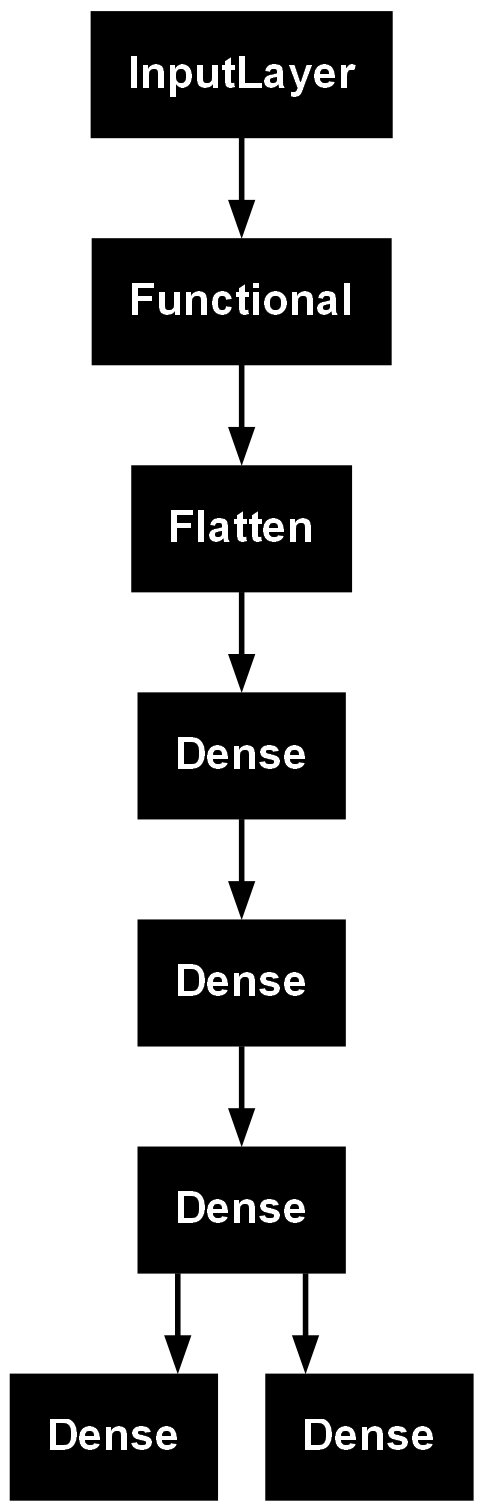

In [57]:
tensorflow.keras.utils.plot_model(model)

In [58]:
model.save('model_problem3_untrained.keras')

# Train model

In [59]:
model.compile(
    loss={'output_age': 'mae', 'output_gender': 'binary_crossentropy'},
    optimizer=RMSprop(learning_rate=1e-5),
    metrics={'output_age': 'mae', 'output_gender': 'accuracy'},
    loss_weights={'output_age':1, 'output_gender':99}
    )

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset
).history

model.save('model_problem3_trained.keras')

c:\Users\7200\AppData\Local\anaconda3\envs\tf\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


TypeError: `output_signature` must contain objects that are subclass of `tf.TypeSpec` but found <class 'list'> which is not.

# Test Results

In [ ]:
plt.plot(history['loss'], label='Training', color='red')
plt.plot(history['val_loss'], label='Validation', color='blue')
plt.legend()
plt.show()
plt.savefig('loss.png')